In [1]:
# this main code by Ssamot from https://github.com/ssamot/infoGA/blob/master/mnist_snes_example.py
# plot loss function from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# loading data office-31 from Lyu Chaofan 1706987

import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from dataSet import dataSet
from timeit import default_timer as timer
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from keras_helper import NNWeightHelper
from snes import SNES

Using TensorFlow backend.


In [2]:
def train_classifier(model, X, y):
    X_features = model.predict(X)
    clf = RandomForestClassifier(n_estimators=10)
    clf.fit(X_features, y)
    y_pred = clf.predict(X_features)
    return clf, y_pred
def predict_classifier(model, clf, X):
    X_features = model.predict(X)
    return clf.predict(X_features)


In [3]:
# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 31

# use just a small sample of the train set to test
SAMPLE_SIZE = 300
# how many different sets of weights ask() should return for evaluation
POPULATION_SIZE = 10
# how many times we will loop over ask()/tell()
GENERATIONS = 30


In [5]:
Amazon_path = './Original_images/amazon/images'
dslr_path   = './Original_images/dslr/images'
webcam_path = './Original_images/webcam/images'

paths = [Amazon_path, dslr_path, webcam_path]
files = os.listdir(Amazon_path)
labels = {}
count  = 0
for key in files:
    a = {key : count}
    labels.update(a)
    count += 1

images_path = []
dslr = dataSet()
webcam = dataSet()

In [6]:
for dirname in files:
    images_name = os.listdir(dslr_path + '/' + dirname)
    for name in images_name:
        Image_Path = dslr_path + '/' + dirname + '/' + name
        images_path.append(Image_Path)
        image_data = cv2.imread(Image_Path)
        image_data = cv2.resize(image_data, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        image_data = image_data.reshape(img_rows, img_cols, 3)
        dslr.upData(image_data, labels[dirname], labels)
        
dslr.sHape()

In [7]:
for dirname in files:
    images_name = os.listdir(webcam_path + '/' + dirname)
    for name in images_name:
        Image_Path = webcam_path + '/' + dirname + '/' + name
        images_path.append(Image_Path)
        image_data = cv2.imread(Image_Path)
        image_data = cv2.resize(image_data, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        image_data = image_data.reshape(img_rows, img_cols, 3)
        webcam.upData(image_data, labels[dirname], labels)

webcam.sHape()

In [8]:
#label classifier data
x_test = dslr.data
y_test = dslr.label
x_train = webcam.data
y_train = webcam.label

In [9]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# data for domain classifier
x_domain = np.concatenate((x_train,x_test), axis = 0)
y_domain = np.concatenate((np.zeros(y_train.shape[0]), np.ones(y_test.shape[0])),axis = 0)


In [10]:
# Neural network architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',
                 input_shape=(28,28,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))

# this is irrelevant for what we want to achieve
model.compile(loss="mse", optimizer="adam")
print("compilation is over")
nnw = NNWeightHelper(model)
weights = nnw.get_weights()

compilation is over


In [11]:
print("Total number of weights to evolve is:", weights.shape)
all_examples_indices = list(range(x_train.shape[0]))
clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)

test_accuracy = accuracy_score(y_test, y_pred)
print('Non-trained NN Test accuracy:', test_accuracy)
# print('Test MSE:', test_mse)

snes = SNES(weights, 1, POPULATION_SIZE)
p = []
for i in range(0, GENERATIONS):
    start = timer()
    asked = snes.ask()

    # to be provided back to snes
    told = []

    # use a small number of training samples for speed purposes
    subsample_indices = np.random.choice(all_examples_indices, size=SAMPLE_SIZE, replace=False)
    # evaluate on another subset
    subsample_indices_valid = np.random.choice(all_examples_indices, size=SAMPLE_SIZE + 1, replace=False)

    # iterate over the population
    for asked_j in asked:
        # set nn weights
        nnw.set_weights(asked_j)
        # train the classifer and get back the predictions on the training data
        clf, _ = train_classifier(model, x_train[subsample_indices], y_train[subsample_indices])
        # train the domain classifier and get back the predictions on the training data
        clf2, _ = train_classifier(model, x_domain[subsample_indices], y_domain[subsample_indices])
        
        # calculate the label predictions on a different set
        y_pred = predict_classifier(model, clf, x_train[subsample_indices_valid])
        score = accuracy_score(y_train[subsample_indices_valid], y_pred)

        # calculate the domain predictions on a different set
        y_pred1 = predict_classifier(model, clf, x_domain[subsample_indices_valid])
        score1 = accuracy_score(y_domain[subsample_indices_valid], y_pred1)
        total = (score+(2*-score1))
        told.append(total)

    temp = snes.tell(asked, told)
    p.append(temp)
    end = timer()
    print("It took", end - start, "seconds to complete generation", i + 1)
    
nnw.set_weights(snes.center)

# predict on source data
clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_train)
test_accuracy = accuracy_score(y_train, y_pred)
print('Test accuracy on source:', test_accuracy)

# predict on target data

y_pred1 = predict_classifier(model, clf, x_test)
test_accuracy1 = accuracy_score(y_test, y_pred1)
print('Test accuracy on target:', test_accuracy1)

Total number of weights to evolve is: (53714,)


Non-trained NN Test accuracy: 0.07630522088353414


Step 1.0 : 0.5049833887043189 best: 0.5049833887043189 10
It took 5.672343324490884 seconds to complete generation 1


Step 2.0 : 0.5315614617940199 best: 0.5315614617940199 10
It took 5.406509867447876 seconds to complete generation 2


Step 3.0 : 0.46179401993355484 best: 0.5315614617940199 10
It took 5.322374478171442 seconds to complete generation 3


Step 4.0 : 0.39867109634551495 best: 0.5315614617940199 10
It took 5.262772039333683 seconds to complete generation 4


Step 5.0 : 0.5016611295681063 best: 0.5315614617940199 10
It took 5.272057140822039 seconds to complete generation 5


Step 6.0 : 0.4950166112956811 best: 0.5315614617940199 10
It took 5.871233569386668 seconds to complete generation 6


Step 7.0 : 0.47508305647840526 best: 0.5315614617940199 10
It took 5.852634099228439 seconds to complete generation 7


Step 8.0 : 0.5415282392026578 best: 0.5415282392026578 10
It took 5.771216326432743 seconds to complete generation 8


Step 9.0 : 0.415282392026578 best: 0.5415282392026578 10
It took 5.575309218351158 seconds to complete generation 9


Step 10.0 : 0.5182724252491695 best: 0.5415282392026578 10
It took 5.512486684313956 seconds to complete generation 10


Step 11.0 : 0.4651162790697675 best: 0.5415282392026578 10
It took 5.5681317065482006 seconds to complete generation 11


Step 12.0 : 0.48172757475083056 best: 0.5415282392026578 10
It took 5.725693164984747 seconds to complete generation 12


Step 13.0 : 0.49833887043189373 best: 0.5415282392026578 10
It took 6.937759988659849 seconds to complete generation 13


Step 14.0 : 0.5415282392026578 best: 0.5415282392026578 10
It took 6.915238716179218 seconds to complete generation 14


Step 15.0 : 0.5016611295681064 best: 0.5415282392026578 10
It took 6.208895389572632 seconds to complete generation 15


Step 16.0 : 0.521594684385382 best: 0.5415282392026578 10
It took 6.164634243096032 seconds to complete generation 16


Step 17.0 : 0.5083056478405317 best: 0.5415282392026578 10
It took 5.9998607164253315 seconds to complete generation 17


Step 18.0 : 0.48504983388704315 best: 0.5415282392026578 10
It took 5.7203249291857645 seconds to complete generation 18


Step 19.0 : 0.4883720930232558 best: 0.5415282392026578 10
It took 5.470240036728555 seconds to complete generation 19


Step 20.0 : 0.49501661129568103 best: 0.5415282392026578 10
It took 5.399276642215057 seconds to complete generation 20


Step 21.0 : 0.4584717607973422 best: 0.5415282392026578 10
It took 5.339535625035921 seconds to complete generation 21


Step 22.0 : 0.5049833887043189 best: 0.5415282392026578 10
It took 5.333291489491501 seconds to complete generation 22


Step 23.0 : 0.4717607973421927 best: 0.5415282392026578 10
It took 5.4911015426625625 seconds to complete generation 23


Step 24.0 : 0.5049833887043189 best: 0.5415282392026578 10
It took 5.858926190636538 seconds to complete generation 24


Step 25.0 : 0.5049833887043189 best: 0.5415282392026578 10
It took 5.630414031885721 seconds to complete generation 25


Step 26.0 : 0.45847176079734214 best: 0.5415282392026578 10
It took 7.830485895157921 seconds to complete generation 26


Step 27.0 : 0.521594684385382 best: 0.5415282392026578 10
It took 5.657405778187922 seconds to complete generation 27


Step 28.0 : 0.5016611295681064 best: 0.5415282392026578 10
It took 5.434158891175798 seconds to complete generation 28


Step 29.0 : 0.43521594684385384 best: 0.5415282392026578 10
It took 5.410498666932796 seconds to complete generation 29


Step 30.0 : 0.4916943521594685 best: 0.5415282392026578 10
It took 5.441911873342917 seconds to complete generation 30


Test accuracy on source: 0.9987421383647799


Test accuracy on target: 0.11044176706827309


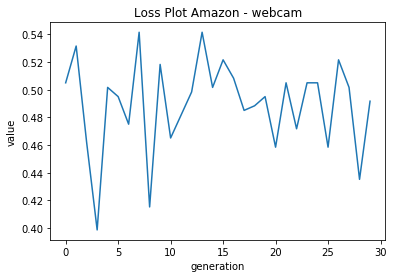

In [12]:
plt.plot(p)
plt.title('Loss Plot Amazon - webcam')
plt.xlabel('generation')
plt.ylabel('value')
plt.savefig('Plot_dslr_webcam.png')
plt.show()